# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
# import ML tools
import numpy as np
from sklearn.cluster import KMeans, AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import calendar

In [3]:
# import plotting tools
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
Use "mp.my_pallete[<slice>]" as palette attribute for Seaborn plots.
This is your color palette...


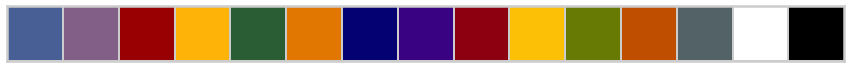

In [4]:
# import custom palette
import my_palette as mp

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [5]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [6]:
# look for missing values or empty strings
np.sum(df_offers.replace('', np.nan).isnull())

offer_id     0
campaign     0
varietal     0
min_qty      0
discount     0
origin       0
past_peak    0
dtype: int64

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [7]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [8]:
# look for missing values or empty strings
np.sum(df_transactions.replace('', np.nan).isnull())

customer_name    0
offer_id         0
n                0
dtype: int64

## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [9]:
#your turn

In [10]:
# observe merged DataFrame
pd.merge(df_offers, df_transactions)

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1
...,...,...,...,...,...,...,...,...,...
319,31,December,Champagne,72,89,France,False,Fisher,1
320,32,December,Cabernet Sauvignon,72,45,Germany,True,Young,1
321,32,December,Cabernet Sauvignon,72,45,Germany,True,Cooper,1
322,32,December,Cabernet Sauvignon,72,45,Germany,True,Gomez,1


In [11]:
# observe merged DataFrames after pivot
pd.merge(df_offers, df_transactions).pivot_table(index='customer_name', columns='offer_id', values='n')

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
Allen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Bailey,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Baker,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Wilson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Wood,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [12]:
# merge then pivot and fill missing values with zeros
customer_df = pd.merge(df_offers, df_transactions).pivot_table(index='customer_name', columns='offer_id', 
                                                               values='n').fillna(0).reset_index()
customer_df.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [13]:
# your turn


Because we want to minimize the distance between data points in a cluster and that cluster's centroid, we want the sum-of-squares error to be small.<br>
The smaller this distance (inertia) is, the more the data points within that cluster will look like each other.<br>
This is the objective of grouping data points by clustering.

In [14]:
# create predictor Numpy matrix
x_cols = np.array(customer_df.drop('customer_name', axis=1))
x_cols

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [15]:
# instantiate model starting with default number of clusters, K = 8
model = KMeans(random_state=27)

In [16]:
# fit model to training data
model.fit(x_cols)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=27, tol=0.0001, verbose=0)

In [17]:
# set range for K values to try
ks = range(2, 11)

In [18]:
# create empty inertia and distortion lists
inertias = []
distortions = []

In [19]:
# fit models with different K values
for k in ks:
    model = KMeans(n_clusters=k, random_state=27)
    model.fit(x_cols)
    inertias.append(model.inertia_)
    distortions.append(sum(np.min(cdist(x_cols, model.cluster_centers_, 'euclidean'),axis=1)) / x_cols.shape[0])

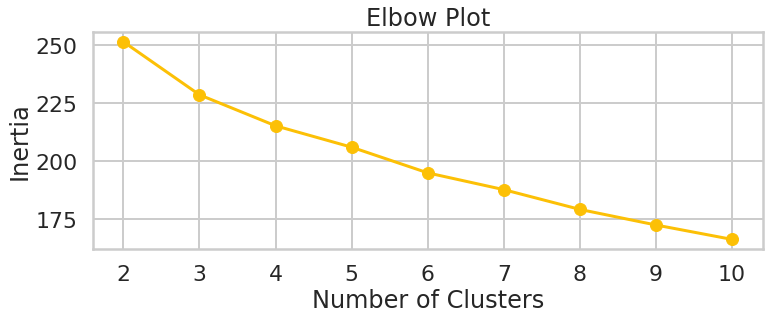

In [20]:
# plot inertias to find elbow

plt.plot(ks, inertias, '-o', c=mp.colors(9))

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.title('Elbow Plot');

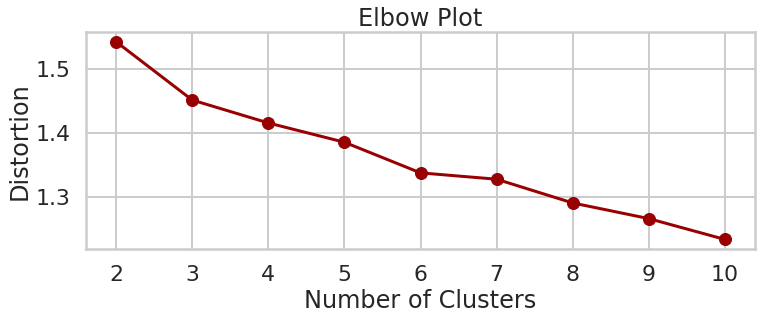

In [21]:
# plot distortions to find elbow

plt.plot(ks, distortions, '-o', c=mp.colors(2))

plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')

plt.title('Elbow Plot');

From the inertia plot, K = 3 is the best choice to minimize the mean distance between the centroids and their respective data points.<br>
The distortion plot is a bit bumpy, but K = 3 has an elbow, as well.

In [22]:
# set number of clusters
n_clusters = 3

In [23]:
# instantiate model starting with best number of clusters, K = 3
km_cl = KMeans(n_clusters=n_clusters, random_state=27)

In [24]:
# fit model to training data
km_cl.fit(x_cols)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=27, tol=0.0001, verbose=0)

In [25]:
# get labels for clusters
labels = km_cl.predict(x_cols)

In [26]:
# get count of labels
pd.DataFrame(np.unique(labels, return_counts=True)).reset_index(0, drop=True).drop(0).rename({1: 'count'})

,0,1,2
count,60,15,25


In [27]:
# assign customers to cluster labels
customer_df['cluster'] = labels
customer_df.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,cluster
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


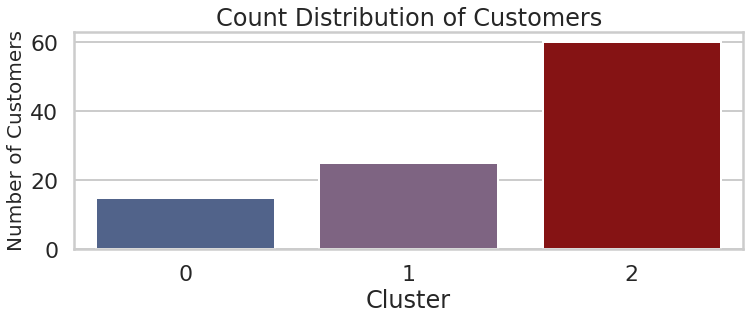

In [28]:
# plot counts of customers in each cluster

sns.barplot(x=customer_df['cluster'], y=customer_df['cluster'].value_counts(), palette=mp.my_palette)

plt.xlabel('Cluster')
plt.ylabel('Number of Customers', size=20)

plt.title('Count Distribution of Customers');

The method for finding the best value for K is simple.<br>
The both elbow plots showed this value, although this is not always the case.<br>
Cluster number 2 has many points, making the data unbalanced.<br>
It may be possible to further cluster this group, if necessary.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [29]:
# Your turn.


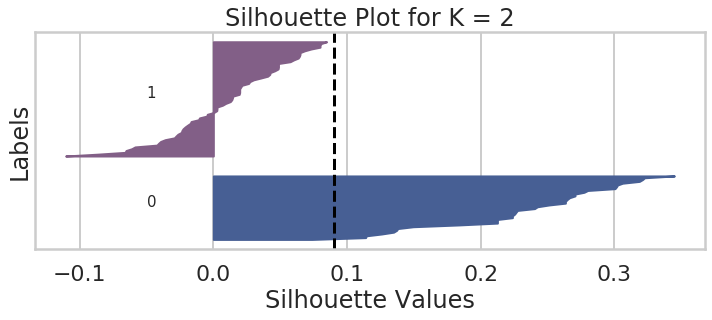

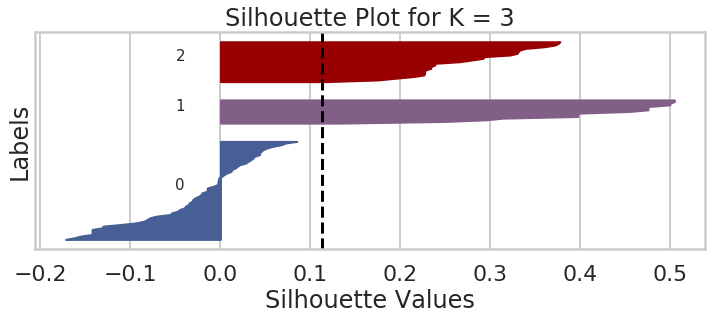

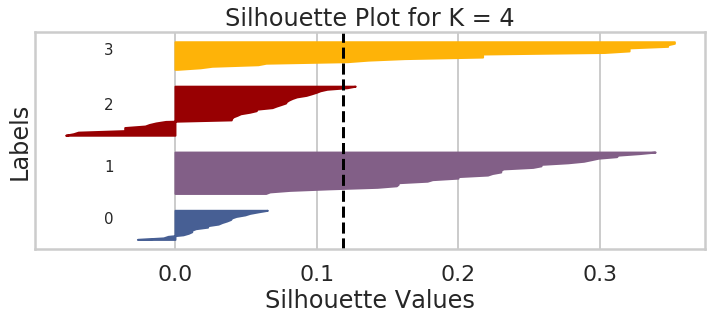

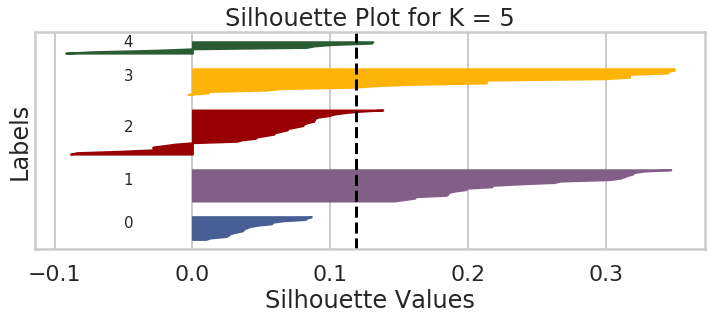

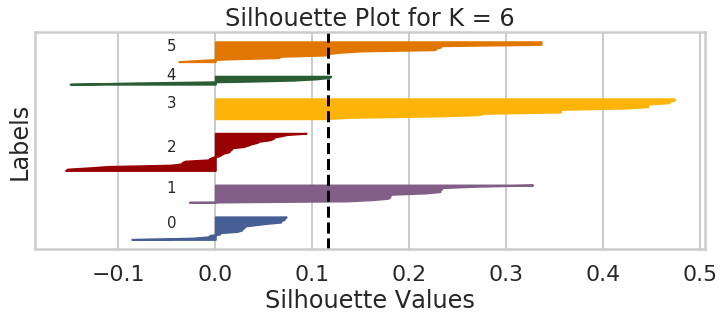

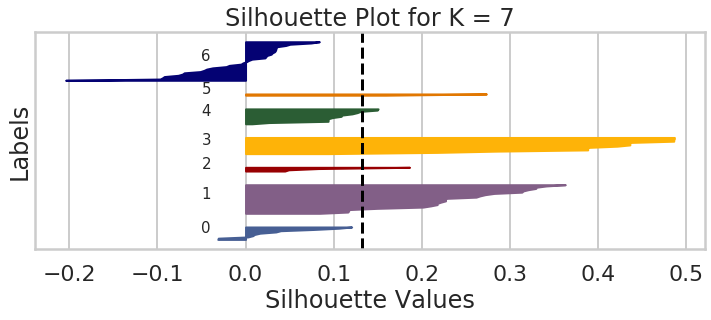

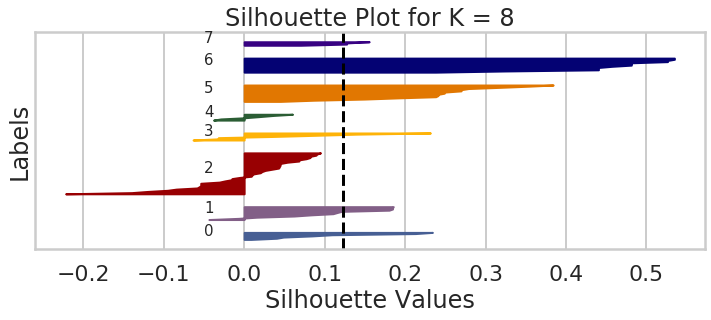

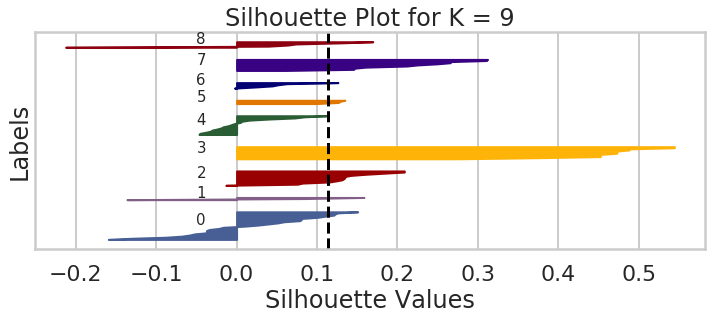

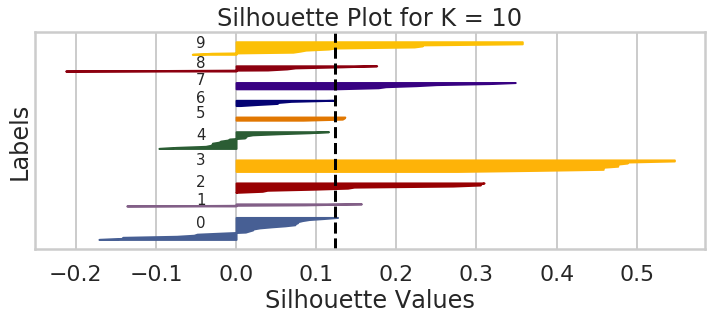

In [30]:
# fit models with different K values, calculate silhouette scores, and plot the silhouette values

# create empty score dict
score_dict = {}

for k in ks:
    # set plot titles for each level
    title_level = f'Silhouette Plot for K = {k}'
    
    f, ax = plt.subplots(1, 1)
    
    # instantiate, train, and predict
    model = KMeans(n_clusters=k, random_state=27)
    model.fit(x_cols)
    labels = model.predict(x_cols)
    
    # save average scores for each cluster
    score_dict[k] = silhouette_score(x_cols, labels)
    
    # get scores for point in cluster
    silhouette_vals = silhouette_samples(x_cols, labels)
    
    # set upper boundary to plot first cluster
    y_lower = 10
    
    for i in range(k):
        # get scores for points in cluster
        kth_vals = silhouette_vals[labels == i]
        # sort scores
        kth_vals.sort()
        # count scores
        kth_count = kth_vals.shape[0]
        
        # set bottom boundary to plot cluster
        y_upper = y_lower + kth_count
        
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, kth_vals, facecolor=mp.colors(i), edgecolor=mp.colors(i))

        # label clusters
        ax.text(-0.05, y_lower + 0.5 * kth_count, str(i), fontsize=15)

        # get new upper boundary to plot next cluster
        y_lower = y_upper + 10
        ax.set_title(title_level)
        
    # make vertical line for average scores of all points
    ax.axvline(x=silhouette_score(x_cols, labels), color='k', linestyle='--')
    
    # clear y ticks
    ax.set_yticks([])

    ax.set_xlabel('Silhouette Values')
    ax.set_ylabel('Labels');

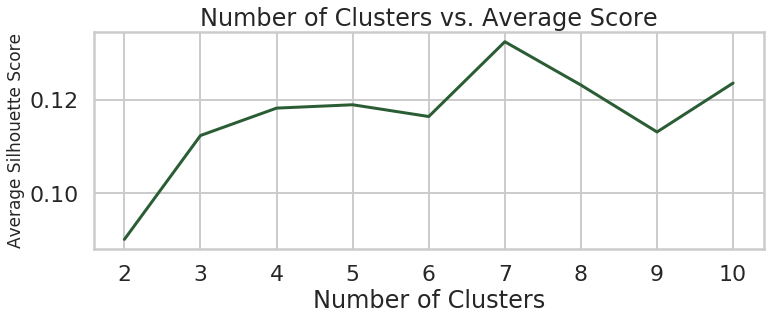

In [31]:
# plot number of clusters vs. average silhouette score

plt.plot(*zip(*sorted(score_dict.items())), color=mp.colors(4))

plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score', fontsize=17)

plt.title('Number of Clusters vs. Average Score');

The best K is 7.<br>
All of the average scores fall below 0.2.<br>
None of the clusterings have substantial structure.

This differs from the value I found with the elbow method.<br>
It may be necessary to observe the effects of adding more clusters.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [32]:
#your turn


In [33]:
# instantiate model
km_model = PCA(n_components=2, random_state=27)

In [34]:
# fit model on predictors
km_model.fit(x_cols)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=27,
    svd_solver='auto', tol=0.0, whiten=False)

In [35]:
# get transformed matrix
km_transformed = km_model.transform(x_cols)

In [36]:
# create DataFrame
km_df = pd.DataFrame(customer_df[['customer_name', 'cluster']]).join(pd.DataFrame(km_transformed)).rename(
    columns={0: 'x', 1: 'y'})
km_df.head(3)

,customer_name,cluster,x,y
0,Adams,2,1.007580,0.108215
1,Allen,0,-0.287539,0.044715
2,Anderson,1,-0.392032,1.038391


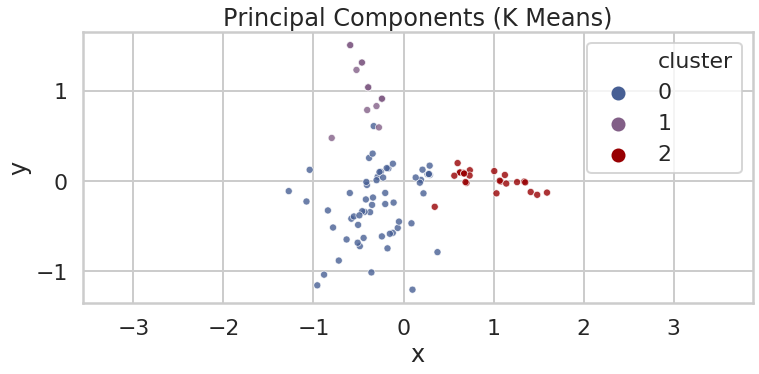

In [116]:
# plot principal components

sns.scatterplot(data=km_df, x='x', y='y', s=50, hue='cluster', palette=mp.my_palette[:n_clusters], alpha=0.8)
plt.axis('equal')

plt.title('Principal Components (K Means)');

The clusters look distinct.<br>
There are a couple of points that stray into neighboring clusters, but the results of this method are the clearest, so far.<br>
As observed earlier, further clustering of the second cluster may reveal more internal structure.

From the PCA plot, the best choice is K = 3.<br>
Visually speaking, the method that leads to the clearest choice of number of clusters is PCA.

In [38]:
# create new DataFrame with desired features
cluster_df = pd.merge(pd.merge(df_offers, df_transactions), km_df[['customer_name', 'cluster']]).drop(
    ['offer_id', 'n'], axis=1)
cluster_df

,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,cluster
0,January,Malbec,72,56,France,False,Thomas,0
1,February,Champagne,72,48,France,True,Thomas,0
2,April,Chardonnay,144,57,Chile,False,Thomas,0
3,May,Champagne,72,85,France,False,Thomas,0
4,June,Merlot,72,64,Chile,False,Thomas,0
...,...,...,...,...,...,...,...,...
319,November,Cabernet Sauvignon,12,56,France,True,Hernandez,0
320,November,Pinot Grigio,6,87,France,False,Hernandez,0
321,November,Pinot Grigio,6,87,France,False,Cruz,2
322,December,Malbec,6,54,France,False,Cruz,2


In [39]:
# get list of month strings
months = [m for m in calendar.month_name[1:]]

In [40]:
# make copy to change data type without changing original
offers_df = df_offers.copy()

In [41]:
# set months as ordered categorical values
cluster_df['campaign'] = pd.Categorical(cluster_df['campaign'], categories=months, ordered=True)
offers_df['campaign'] = pd.Categorical(offers_df['campaign'], categories=months, ordered=True)

In [42]:
# observe what percentage of each varietal of wine was past its peak when purchased (sorted by cluster)
var_pp_df = pd.merge(pd.merge(df_offers, df_transactions), cluster_df.loc[:, ['customer_name', 'cluster']]
                    ).pivot_table(index='cluster', columns='varietal', values='past_peak').fillna(0).mul(100)
var_pp_df

varietal,Cabernet Sauvignon,Champagne,Chardonnay,Espumante,Malbec,Merlot,Pinot Grigio,Pinot Noir,Prosecco
cluster,,,,,,,,,
0,57.51634,16.573034,0.0,45.454545,0.0,0.0,0.0,0.0,23.140496
1,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,83.333333


In [43]:
# melt DataFrame to plot
var_pp_melt_df = var_pp_df.reset_index().melt(id_vars='cluster').rename(columns={'value': 'percent'})

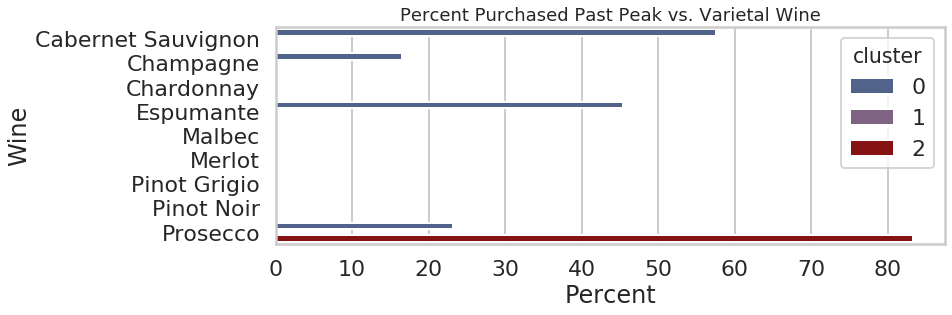

In [44]:
# plot comparison

sns.barplot(data=var_pp_melt_df, x='percent', y='varietal', hue='cluster', orient='h', ci=False)

plt.xlabel('Percent')
plt.ylabel('Wine')
plt.title('Percent Purchased Past Peak vs. Varietal Wine', fontsize=18);

Cluster 1 didn't buy wine past its peak.<br>
Cluster 2 only did so when it was Prosecco. They bought most of their Prosecco this way.

In [45]:
# observe what percentage of wine for each month was past its peak when purchased (sorted by cluster)
cam_pp_df = pd.merge(pd.merge(offers_df, df_transactions), cluster_df.loc[:, ['customer_name', 'cluster']]
                    ).pivot_table(index='cluster', columns='campaign', values='past_peak').fillna(0).mul(100)
cam_pp_df

campaign,January,February,March,April,May,June,July,August,September,October,November,December
cluster,,,,,,,,,,,,
0,0.0,100.0,25.454545,0.0,0.0,0.0,0.0,0.0,0.0,32.926829,77.419355,15.652174
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,0.0,0.0,47.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [46]:
# melt DataFrame to plot
cam_pp_df.columns = cam_pp_df.columns.astype('str')
cam_pp_melt_df = cam_pp_df.reset_index().melt(id_vars='cluster').rename(columns={'value': 'percent'})

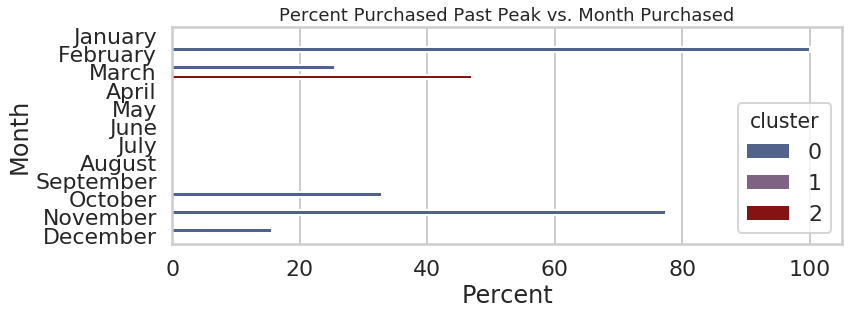

In [47]:
# plot comparison

sns.barplot(data=cam_pp_melt_df, x='percent', y='campaign', hue='cluster', orient='h', ci=False)

plt.xlabel('Percent')
plt.ylabel('Month')
plt.title('Percent Purchased Past Peak vs. Month Purchased', fontsize=18);

All of the wine that cluster 0 bought in February was past its peak. Most of their purchases in November were this way, as well.<br>
Cluster 2 only bought wine past its peak in March.<br>
Wines past their peak were on sale from October through March.<br>
This makes sense, because wines are season releases, and most wines have been released by October.<br>
This would be when they are considered a year older.

In [48]:
# observe what percent of past peak regional wine was bought (sorted by cluster)
ori_pp_df = pd.merge(pd.merge(df_offers, df_transactions), cluster_df.loc[:, ['customer_name', 'cluster']]
                    ).pivot_table(index='cluster', columns='origin', values='past_peak').fillna(0).mul(100)
ori_pp_df

origin,Australia,California,Chile,France,Germany,Italy,New Zealand,Oregon,South Africa
cluster,,,,,,,,,
0,41.791045,0.0,0.0,20.39312,42.857143,0.0,38.77551,91.22807,0.0
1,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.00000,0.00000,0.0
2,100.000000,0.0,0.0,0.00000,0.000000,0.0,0.00000,0.00000,0.0


In [49]:
# melt DataFrame to plot
ori_pp_melt_df = ori_pp_df.reset_index().melt(id_vars='cluster').rename(columns={'value': 'percent'})

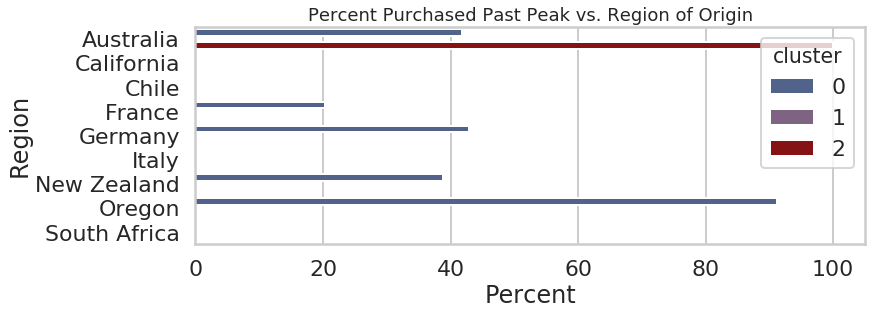

In [50]:
# plot comparison

sns.barplot(data=ori_pp_melt_df, x='percent', y='origin', hue='cluster', orient='h', ci=False)

plt.xlabel('Percent')
plt.ylabel('Region')
plt.title('Percent Purchased Past Peak vs. Region of Origin', fontsize=18);

Most of the wine that cluster 0 bought from Oregon was past its peak.<br>
All of the wine that was past its peak bought by cluster 2 came from Australia.

In [51]:
# observe average percent discount of each varietal of wine that was purchased (sorted by cluster)
var_dis_df = pd.merge(pd.merge(df_offers, df_transactions), cluster_df.loc[:, ['customer_name', 'cluster']]
                    ).pivot_table(index='cluster', columns='varietal', values='discount').fillna(0)
var_dis_df

varietal,Cabernet Sauvignon,Champagne,Chardonnay,Espumante,Malbec,Merlot,Pinot Grigio,Pinot Noir,Prosecco
cluster,,,,,,,,,
0,51.614379,71.070225,51.813559,39.545455,55.287671,72.262295,87.0,56.285714,68.826446
1,0.000000,88.000000,39.000000,0.000000,56.000000,0.000000,0.0,48.144231,52.000000
2,0.000000,0.000000,0.000000,47.437500,54.000000,43.000000,87.0,0.000000,44.833333


In [52]:
# melt DataFrame to plot
var_dis_melt_df = var_dis_df.reset_index().melt(id_vars='cluster').rename(columns={'value': 'percent'})

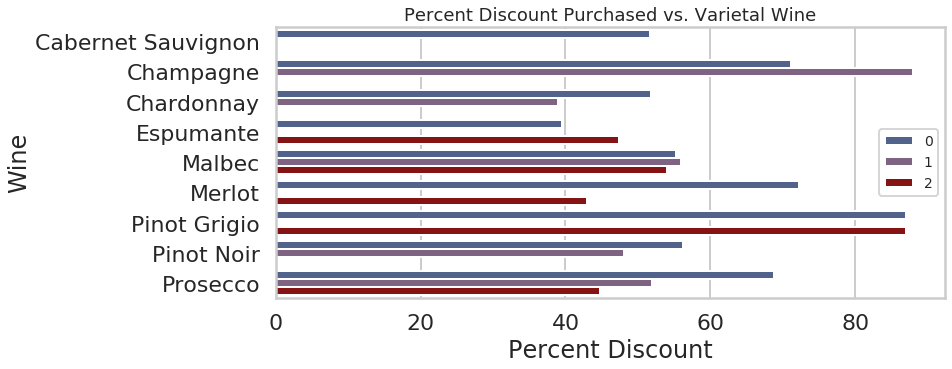

In [53]:
# plot comparison
figsize(12, 5)

sns.barplot(data=var_dis_melt_df, x='percent', y='varietal', hue='cluster', orient='h', ci=False)

plt.legend(loc=5, fontsize='xx-small')

plt.xlabel('Percent Discount')
plt.ylabel('Wine')
plt.title('Percent Discount Purchased vs. Varietal Wine', fontsize=18);

Clusters 0 and 2 received the biggest discount on Pinot Grigio.<br>
Cluster 1 received their biggest discount on Champagne.

In [54]:
# observe average percent discount from each wine region that was purchased (sorted by cluster)
ori_dis_df = pd.merge(pd.merge(df_offers, df_transactions), cluster_df.loc[:, ['customer_name', 'cluster']]
                    ).pivot_table(index='cluster', columns='origin', values='discount').fillna(0)
ori_dis_df

origin,Australia,California,Chile,France,Germany,Italy,New Zealand,Oregon,South Africa
cluster,,,,,,,,,
0,65.029851,64.271186,70.906475,65.245700,57.0,50.984615,70.938776,46.368421,42.571429
1,83.000000,52.000000,0.000000,25.666667,47.0,34.000000,88.000000,0.000000,39.000000
2,40.000000,52.000000,48.931034,69.489796,0.0,0.000000,0.000000,50.000000,45.000000


In [55]:
# melt DataFrame to plot
ori_dis_melt_df = ori_dis_df.reset_index().melt(id_vars='cluster').rename(columns={'value': 'percent'})

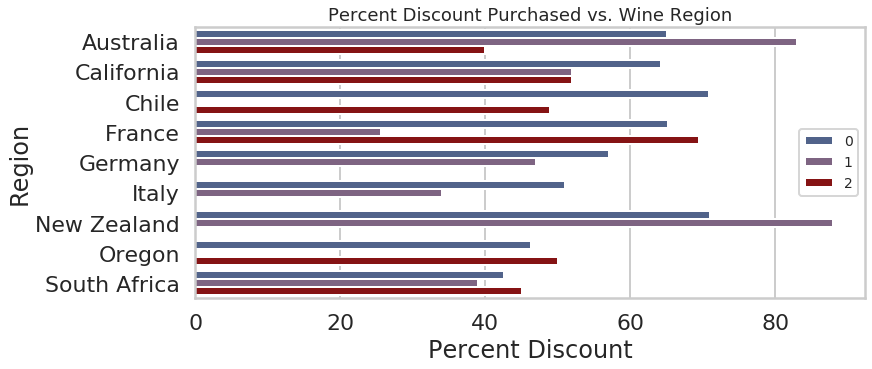

In [56]:
# plot comparison

figsize(12, 5)

sns.barplot(data=ori_dis_melt_df, x='percent', y='origin', hue='cluster', orient='h', ci=False)

plt.legend(loc=5, fontsize='xx-small')

plt.xlabel('Percent Discount')
plt.ylabel('Region')
plt.title('Percent Discount Purchased vs. Wine Region', fontsize=18);

Cluster 1 got the biggest discount on wines from Oceania.<br>
Cluster 2 preferred to get discounts on Franch wine.

In [57]:
# observe average percent discount for each month that was purchased (sorted by cluster)
cam_dis_df = pd.merge(pd.merge(offers_df, df_transactions), cluster_df.loc[:, ['customer_name', 'cluster']]
                    ).pivot_table(index='cluster', columns='campaign', values='discount').fillna(0)
cam_dis_df

campaign,January,February,March,April,May,June,July,August,September,October,November,December
cluster,,,,,,,,,,,,
0,45.640625,43.378641,64.972727,55.28125,84.616438,53.935484,63.241379,65.869863,39.000000,76.926829,63.0,74.2
1,25.666667,0.000000,0.000000,52.00000,0.000000,0.000000,47.000000,0.000000,34.810811,83.789474,0.0,0.0
2,0.000000,0.000000,44.576471,52.00000,43.000000,0.000000,50.000000,0.000000,0.000000,0.000000,87.0,54.0


In [58]:
# melt DataFrame to plot
cam_dis_df.columns = cam_dis_df.columns.astype('str')
cam_dis_melt_df = cam_dis_df.reset_index().melt(id_vars='cluster').rename(columns={'value': 'percent'})

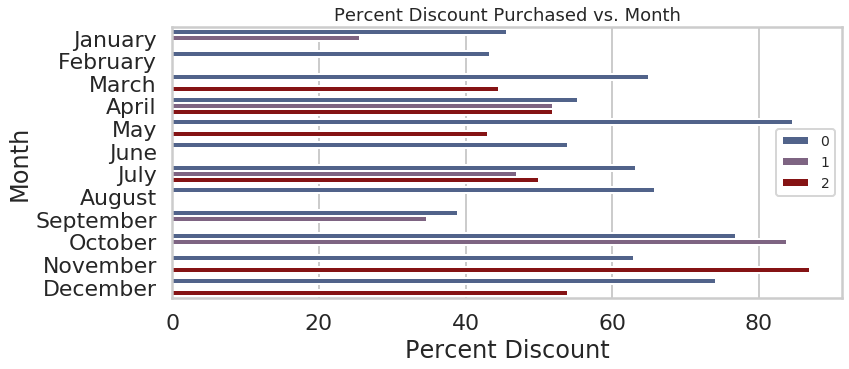

In [59]:
# plot comparison

figsize(12, 5)

sns.barplot(data=cam_dis_melt_df, x='percent', y='campaign', hue='cluster', orient='h', ci=False)

plt.legend(loc=5, fontsize='xx-small')

plt.xlabel('Percent Discount')
plt.ylabel('Month')
plt.title('Percent Discount Purchased vs. Month', fontsize=18);

Cluster 0 got their biggest discount in May.<br>
Cluster 1 got theirs in October.<br>
Cluster 2 took advantage of discounts in November.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [60]:
#your turn
# Initialize a new PCA model with a default number of components.
pca = PCA(random_state=27)
pca.fit(x_cols)

# Do the rest on your own :)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=27,
    svd_solver='auto', tol=0.0, whiten=False)

In [61]:
# get range of PCA features
features = range(pca.n_components_)

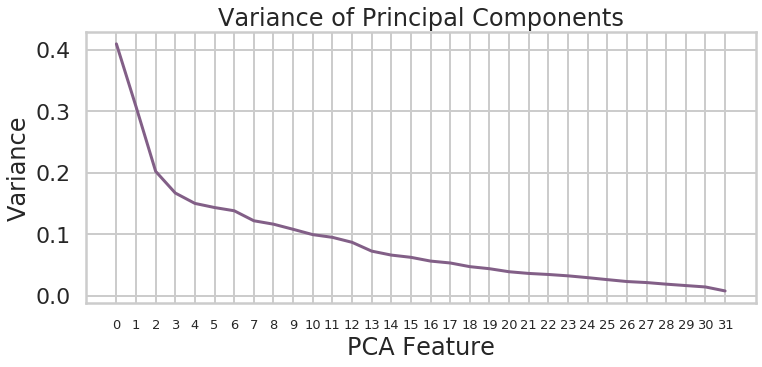

In [62]:
# plot sorted variances of all principal components

plt.plot(features, pca.explained_variance_, color=mp.my_palette[1])

plt.xticks(features, fontsize=13)

plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('Variance of Principal Components');

The elbow is at 2 PCA features. The effect of this choice for the number of components was observed above.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [63]:
# Your turn

In [64]:
# instantiate affinity propagation model with default preference
ap_default_cl = AffinityPropagation()

In [65]:
# fit model to predictors
ap_default_cl.fit(x_cols)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=200, preference=None, verbose=False)

In [66]:
# observe number of clusters
len(ap_default_cl.cluster_centers_indices_)

14

The default model gives 14 clusters.<br>
After plotting these clusters, I confirmed that this clustering is not heplful.<br>
I will tune the preference parameter such that I get 3 clusters to enable comparision with the other models.

In [67]:
# instantiate affinity propagation model to get 3 clusters
ap_cl = AffinityPropagation(preference=-34)

In [68]:
# fit model to predictors
ap_cl.fit(x_cols)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=200, preference=-34, verbose=False)

In [69]:
# check number of clusters
len(ap_cl.cluster_centers_indices_)

3

In [70]:
# get cluster labels
labels = ap_cl.labels_

In [71]:
# get count of labels
pd.DataFrame(np.unique(labels, return_counts=True)).reset_index(0, drop=True).drop(0).rename({1: 'count'})

,0,1,2
count,19,27,54


In [72]:
# assign customers to cluster labels
customer_df['cluster'] = labels
customer_df.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,cluster
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2


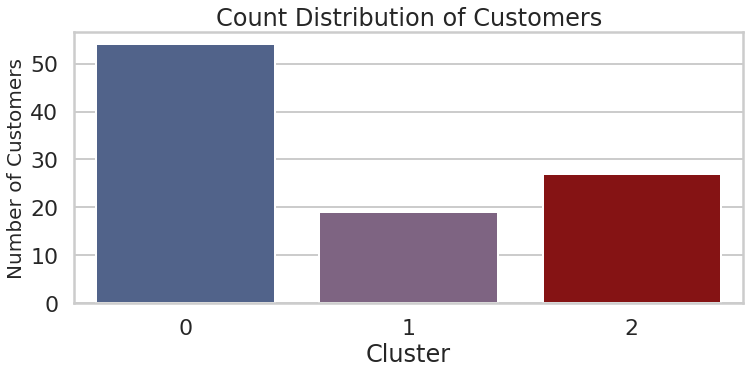

In [73]:
# plot counts of customers in each cluster

sns.barplot(x=customer_df['cluster'], y=customer_df['cluster'].value_counts(), palette=mp.my_palette)

plt.xlabel('Cluster')
plt.ylabel('Number of Customers', size=20)

plt.title('Count Distribution of Customers');

In [74]:
# instantiate model
ap_model = PCA(n_components=2, random_state=27)

In [75]:
# fit model on predictors
ap_model.fit(x_cols)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=27,
    svd_solver='auto', tol=0.0, whiten=False)

In [76]:
# get transformed matrix
ap_transformed = ap_model.transform(x_cols)

In [77]:
# create DataFrame
ap_df = pd.DataFrame(customer_df[['customer_name', 'cluster']]).join(pd.DataFrame(ap_transformed)).rename(
    columns={0: 'x', 1: 'y'})
ap_df.head(3)

,customer_name,cluster,x,y
0,Adams,1,1.007580,0.108215
1,Allen,2,-0.287539,0.044715
2,Anderson,0,-0.392032,1.038391


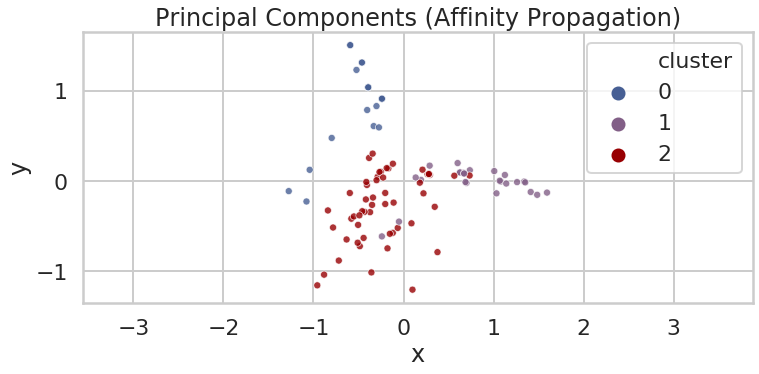

In [117]:
# plot principal components

sns.scatterplot(data=ap_df, x='x', y='y', s=50, hue='cluster', palette=mp.my_palette[:n_clusters], alpha=0.8)
plt.axis('equal')

plt.title('Principal Components (Affinity Propagation)');

The clustering with the affinity propagation model is not as distinct as it was using the K means model.<br>
There is more bleeding of points in clusters 1 and 2 into each other.<br>
Cluster 0 has been completely separated from cluster 2.<br>
It now has points to the left of the blob, instead of only above it.

With this model, we are not supposed to have to choose the number of clusters.<br>
Unfortunately, the out of the box model gives terrible results, and that is what I ended up doing, anyways.<br>

In [79]:
# instantiate spectral clustering model
sc_cl = SpectralClustering(n_clusters=n_clusters, random_state=27)

In [80]:
# fit model to predictors
sc_cl.fit(x_cols)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=3, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=10, random_state=27)

In [81]:
# get cluster labels
labels = sc_cl.labels_

In [82]:
# get count of labels
pd.DataFrame(np.unique(labels, return_counts=True)).reset_index(0, drop=True).drop(0).rename({1: 'count'})

,0,1,2
count,31,55,14


In [83]:
# assign customers to cluster labels
customer_df['cluster'] = labels
customer_df.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,cluster
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


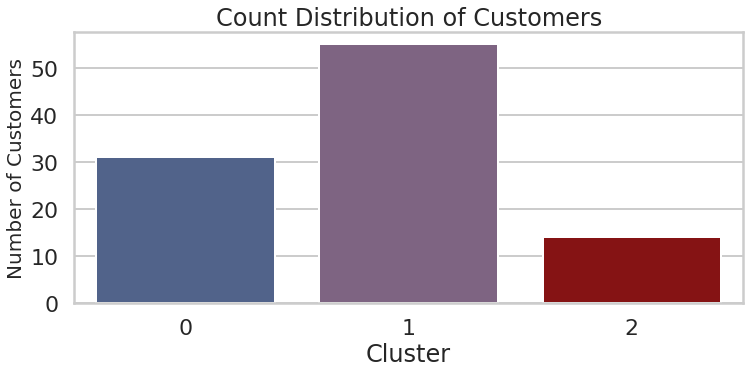

In [84]:
# plot counts of customers in each cluster

sns.barplot(x=customer_df['cluster'], y=customer_df['cluster'].value_counts(), palette=mp.my_palette)

plt.xlabel('Cluster')
plt.ylabel('Number of Customers', size=20)

plt.title('Count Distribution of Customers');

In [85]:
# instantiate model
sc_model = PCA(n_components=2, random_state=27)

In [86]:
# fit model on predictors
sc_model.fit(x_cols)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=27,
    svd_solver='auto', tol=0.0, whiten=False)

In [87]:
# get transformed matrix
sc_transformed = sc_model.transform(x_cols)

In [88]:
# create DataFrame
sc_df = pd.DataFrame(customer_df[['customer_name', 'cluster']]).join(pd.DataFrame(sc_transformed)).rename(
    columns={0: 'x', 1: 'y'})
sc_df.head(3)

,customer_name,cluster,x,y
0,Adams,0,1.007580,0.108215
1,Allen,1,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391


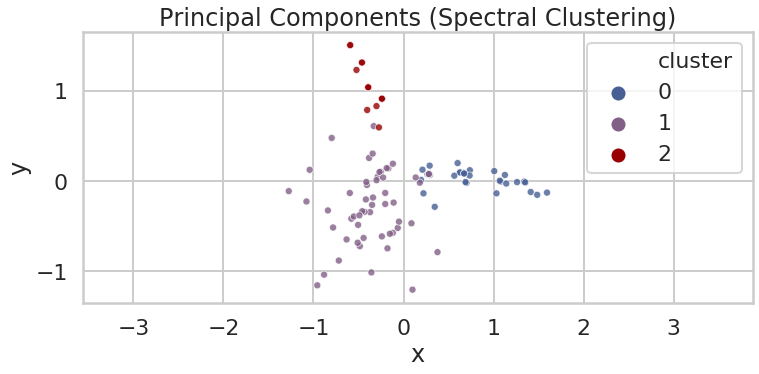

In [118]:
# plot principal components

sns.scatterplot(data=sc_df, x='x', y='y', s=50, hue='cluster', palette=mp.my_palette[:n_clusters], alpha=0.8)
plt.axis('equal')

plt.title('Principal Components (Spectral Clustering)');

The clusters from the spectral clustering model are similar to those from the K means model.<br>
There is slightly more bleeding of points between clusters, but not as much as with the affinity propagation model.

In [90]:
# instantiate agglomerative clustering model
ac_cl = AgglomerativeClustering(n_clusters=n_clusters)

In [91]:
# fit model to predictors
ac_cl.fit(x_cols)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=3)

In [92]:
# get cluster labels
labels = ac_cl.labels_

In [93]:
# get count of labels
pd.DataFrame(np.unique(labels, return_counts=True)).reset_index(0, drop=True).drop(0).rename({1: 'count'})

,0,1,2
count,49,34,17


In [94]:
# assign customers to cluster labels
customer_df['cluster'] = labels
customer_df.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,cluster
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


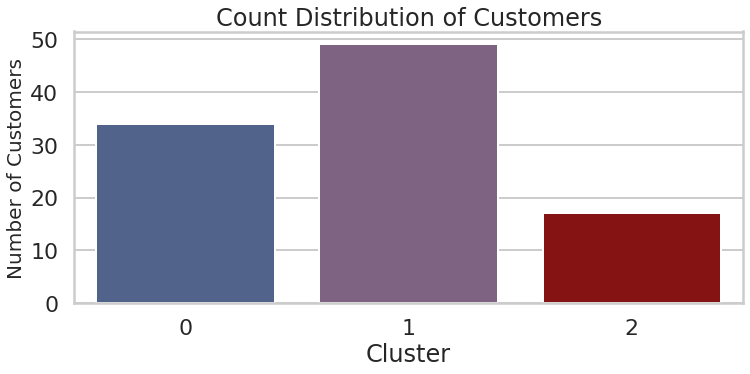

In [95]:
# plot counts of customers in each cluster

sns.barplot(x=customer_df['cluster'], y=customer_df['cluster'].value_counts(), palette=mp.my_palette)

plt.xlabel('Cluster')
plt.ylabel('Number of Customers', size=20)

plt.title('Count Distribution of Customers');

In [96]:
# instantiate model
ac_model = PCA(n_components=2, random_state=27)

In [97]:
# fit model on predictors
ac_model.fit(x_cols)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=27,
    svd_solver='auto', tol=0.0, whiten=False)

In [98]:
# get transformed matrix
ac_transformed = ac_model.transform(x_cols)

In [99]:
# create DataFrame
ac_df = pd.DataFrame(customer_df[['customer_name', 'cluster']]).join(pd.DataFrame(ac_transformed)).rename(
    columns={0: 'x', 1: 'y'})
ac_df.head(3)

,customer_name,cluster,x,y
0,Adams,1,1.007580,0.108215
1,Allen,0,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391


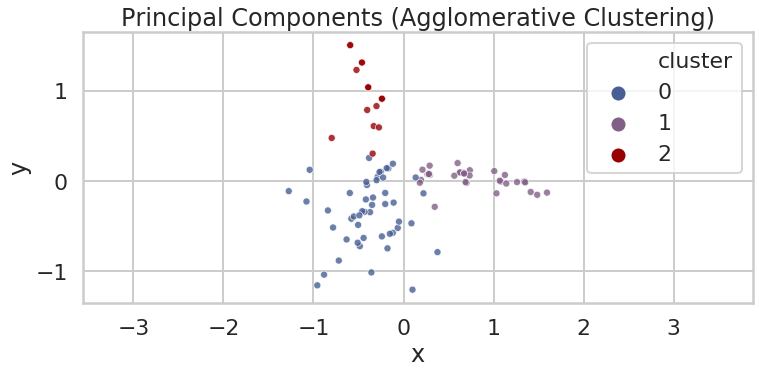

In [119]:
# plot principal components

sns.scatterplot(data=ac_df, x='x', y='y', s=50, hue='cluster', palette=mp.my_palette[:n_clusters], alpha=0.8)
plt.axis('equal')

plt.title('Principal Components (Agglomerative Clustering)');

In [101]:
# instantiate DBSCAN model
db_cl = DBSCAN(eps=1, min_samples=4)

In [102]:
# fit model to predictors
db_cl.fit(x_cols)

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=4, n_jobs=None, p=None)

In [103]:
# get cluster labels
labels = db_cl.labels_

In [104]:
# observe extra noise cluster
np.unique(labels, return_counts=True)

(array([-1,  0,  1,  2]), array([56, 26, 14,  4]))

In [105]:
# get count of labels
pd.DataFrame(np.unique(labels, return_counts=True), columns=np.unique(labels, return_counts=True)[0]
            ).drop(0).rename(index={1: 'count'}, columns={-1: 'noise'})

,noise,0,1,2
count,56,26,14,4


In [106]:
# observe number of clusters, not including points considered noise
len(set(labels)) - (1 if -1 in labels else 0)

3

In [107]:
# assign customers to cluster labels
customer_df['cluster'] = [x if x != -1 else 'noise' for x in labels]
customer_df.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,cluster
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,noise


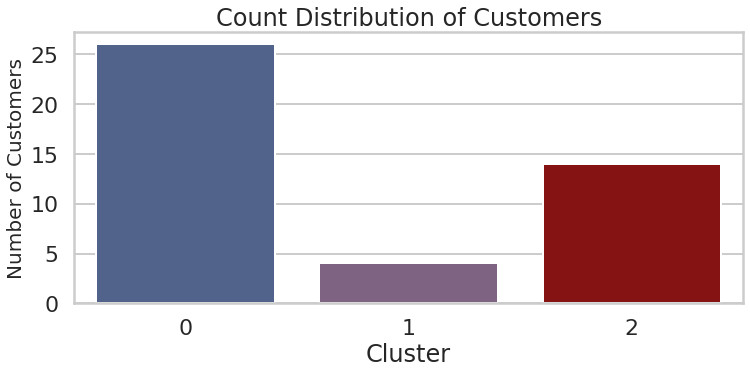

In [108]:
# plot counts of customers in each cluster

sns.barplot(x=customer_df[customer_df['cluster'] != 'noise']['cluster'], y=customer_df['cluster'].value_counts(), 
            palette=mp.my_palette)

plt.xlabel('Cluster')
plt.ylabel('Number of Customers', size=20)

plt.title('Count Distribution of Customers');

In [109]:
# instantiate model
db_model = PCA(n_components=2, random_state=27)

In [110]:
# fit model on predictors
db_model.fit(x_cols)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=27,
    svd_solver='auto', tol=0.0, whiten=False)

In [111]:
# get transformed matrix
db_transformed = db_model.transform(x_cols)

In [112]:
# reassign cluster labels back to all numerical for scatter plot
customer_df['cluster'] = labels

In [113]:
# create DataFrame
db_df = pd.DataFrame(customer_df[['customer_name', 'cluster']]).join(pd.DataFrame(ac_transformed)).rename(
    columns={0: 'x', 1: 'y'})
db_df.head()

,customer_name,cluster,x,y
0,Adams,0,1.007580,0.108215
1,Allen,2,-0.287539,0.044715
2,Anderson,1,-0.392032,1.038391
3,Bailey,0,0.699477,-0.022542
4,Baker,-1,0.088183,-0.471695


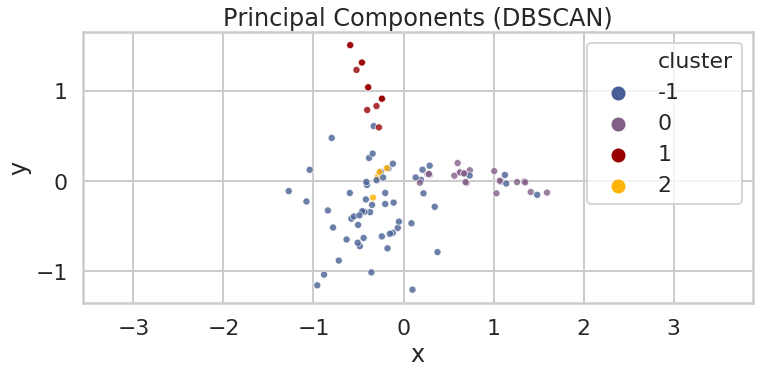

In [120]:
# plot principal components

sns.scatterplot(data=db_df, x='x', y='y', s=50, hue='cluster', palette=mp.my_palette[:n_clusters + 1], alpha=0.8)
plt.axis('equal')

plt.title('Principal Components (DBSCAN)');

This model classified the largest cluster as noise.<br>
The two distinct clusters are 0 and 1.<br>
I believe that the largest clusters of each model need to be analyzed independently to discover if they can be  clustered internally.<br>
Cluster 2 may be a sign of further structure within the noise.

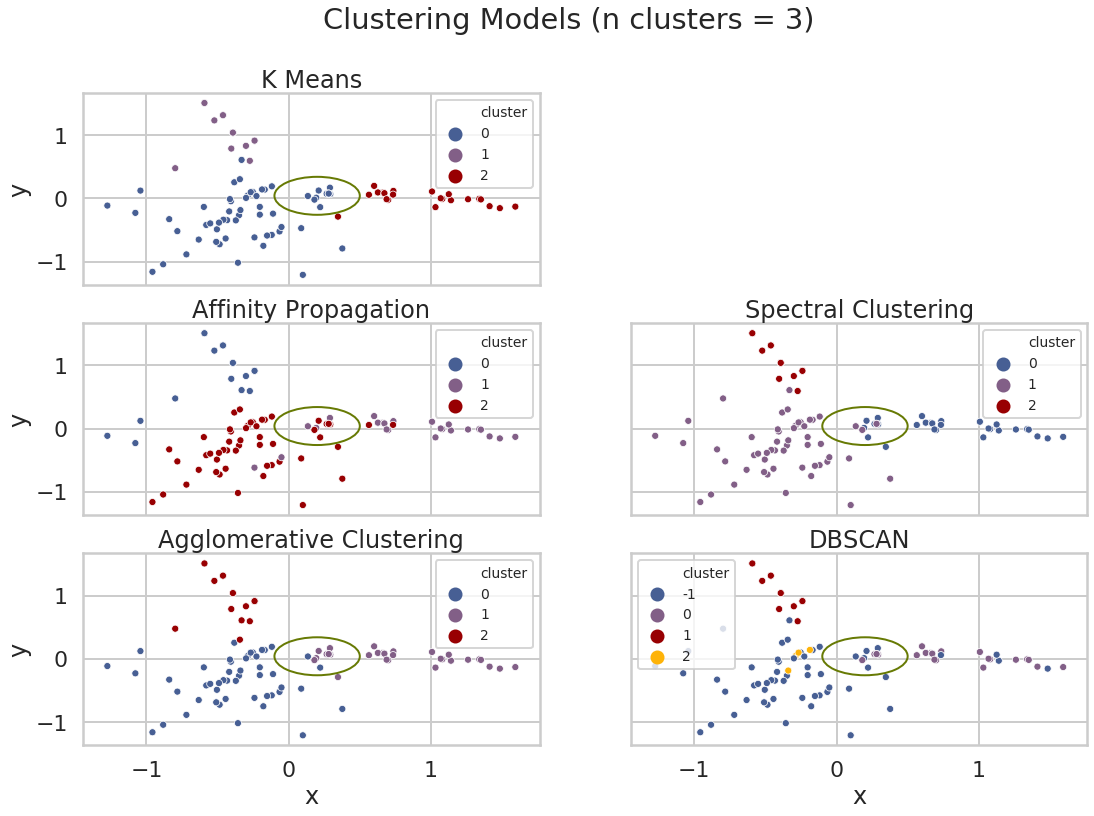

In [153]:
# plot all 5 cluster scatter plots

fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)
fig.delaxes(axes[0,1])

sns.scatterplot(data=km_df, x='x', y='y', s=50, hue='cluster', palette=mp.my_palette[:n_clusters], ax=axes[0, 0])
sns.scatterplot(data=ap_df, x='x', y='y', s=50, hue='cluster', palette=mp.my_palette[:n_clusters], ax=axes[1, 0])
sns.scatterplot(data=sc_df, x='x', y='y', s=50, hue='cluster', palette=mp.my_palette[:n_clusters], ax=axes[1, 1])
sns.scatterplot(data=ac_df, x='x', y='y', s=50, hue='cluster', palette=mp.my_palette[:n_clusters], ax=axes[2, 0])
sns.scatterplot(data=db_df, x='x', y='y', s=50, hue='cluster', palette=mp.my_palette[:n_clusters + 1], ax=axes[2, 1])

for ax in fig.get_axes():
    ax.label_outer()
    
circle1 = plt.Circle((0.2, 0.04), 0.3, color=mp.colors(10), fill=False)
circle2 = plt.Circle((0.2, 0.04), 0.3, color=mp.colors(10), fill=False)
circle3 = plt.Circle((0.2, 0.04), 0.3, color=mp.colors(10), fill=False)
circle4 = plt.Circle((0.2, 0.04), 0.3, color=mp.colors(10), fill=False)
circle5 = plt.Circle((0.2, 0.04), 0.3, color=mp.colors(10), fill=False)

axes[0, 0].add_artist(circle1)
axes[1, 0].add_artist(circle2)
axes[1, 1].add_artist(circle3)
axes[2, 0].add_artist(circle4)
axes[2, 1].add_artist(circle5)

axes[0, 0].legend(fontsize='xx-small')
axes[1, 0].legend(fontsize='xx-small')
axes[1, 1].legend(fontsize='xx-small')
axes[2, 0].legend(fontsize='xx-small')
axes[2, 1].legend(fontsize='xx-small')

axes[0, 0].set_title('K Means')
axes[1, 0].set_title('Affinity Propagation')
axes[1, 1].set_title('Spectral Clustering')
axes[2, 0].set_title('Agglomerative Clustering')
axes[2, 1].set_title('DBSCAN')
fig.suptitle('Clustering Models (n clusters = 3)');

If we decide on having 3 clusters, K means looks like the best model, visually.<br>
There is the most disagreement between the models on the clustering of the points to the right of the large blob.<br>
Only the k means model assigned all the points in that region to one cluster.